# Face generation with DCGAN

В этом ноутбуке мы научим нейронную сеть генерировать лица людей.

In [32]:
from importlib import reload
import dataset
import train
import utils
import models
reload(utils)
reload(dataset)
reload(train)
reload(models)

<module 'models' from 'D:\\Projects\\ML\\DLS\\DCGAN_FaceGeneration\\models.py'>

In [33]:
# !git init .
# !git remote add -f origin "https://github.com/Sankek/DCGAN_FaceGeneration"
# !git pull origin master

In [10]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from dataset import FacesDataset
from utils import tensor2image, load_models, save_models, random_noise_vectors
from models import DiscriminatorNet, GeneratorNet, weights_init
from train import train

In [2]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Current device: {DEVICE}")

Current device: cpu


## Загрузка датасета

Обучать модели будем на части датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), изображения в котором уменьшены до размера 128x128.

In [3]:
batch_size = 16

dataset = FacesDataset(path='faces_dataset_resized', download=True)
dataset_mean = dataset.mean  # Нормализация картинок в датасете
dataset_std = dataset.std
dataloader = DataLoader(dataset, batch_size=batch_size, pin_memory=True)

Loading images...
Images are loaded!


Проверим, что загрузка данных и преобразование из тензоров в обычные изображения работает нормально:

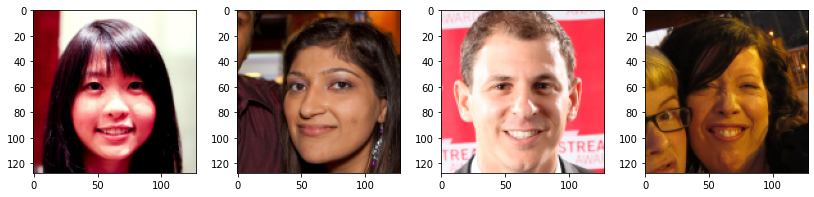

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(14, 3))
example_faces = next(iter(dataloader))
for i in range(4):
    axs[i].imshow(tensor2image(example_faces[i], dataset_mean, dataset_std))
plt.show()

## Инициализация модели

In [5]:
latent_size = 100  # Размер вектора шума, из которого генерируется изображение
generator = GeneratorNet(latent_size)  # на выходе должны быть числа в диапазоне [-1, 1] для корректной работы
discriminator = DiscriminatorNet()

generator = generator.to(DEVICE)
discriminator = discriminator.to(DEVICE)

## Обучение

In [6]:
lr = 1e-4

models = {
    "discriminator": discriminator,
    "generator": generator
}

criterion = nn.BCEWithLogitsLoss()

optimizers = {
    "discriminator": torch.optim.Adam(models['discriminator'].parameters(), lr=lr, betas=(0.5, 0.999)),
    "generator": torch.optim.Adam(models['generator'].parameters(), lr=3*lr, betas=(0.5, 0.999))
}

# Apply the weights_init function to randomly initialize all weights
# with mean=0, stdev=0.02.
models['discriminator'].apply(weights_init)
models['generator'].apply(weights_init)

models['discriminator'].train()
models['generator'].train()

D_losses_real, D_losses_fake, G_losses = [], [], []

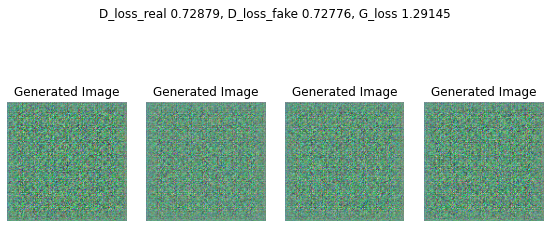

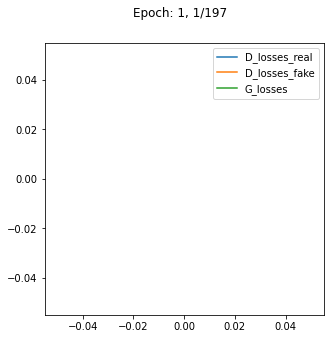

RuntimeError: [enforce fail at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\core\impl\alloc_cpu.cpp:81] data. DefaultCPUAllocator: not enough memory: you tried to allocate 67108864 bytes.

In [36]:
losses_pack = train(
    models, latent_size, criterion, optimizers, dataloader, 
    dataset_mean, dataset_std, epochs=1, device=DEVICE
)

D_losses_real += losses_pack[0]
D_losses_fake += losses_pack[1]
G_losses += losses_pack[2]

In [37]:
# Сохранение модели

losses = [D_losses_real, D_losses_fake, G_losses]
save_name = 'trained'
save_models(
    models['discriminator'], models['generator'], 
    optimizers['discriminator'], optimizers['generator'], 
    losses, save_name
)

In [ ]:
# Загрузка модели

load_name = 'trained'
D_losses_real, D_losses_fake, G_losses = load_models(
    models['discriminator'], models['generator'], 
    optimizers['discriminator'], optimizers['generator'], 
    load_name, device=DEVICE
)

## Просмотр результатов

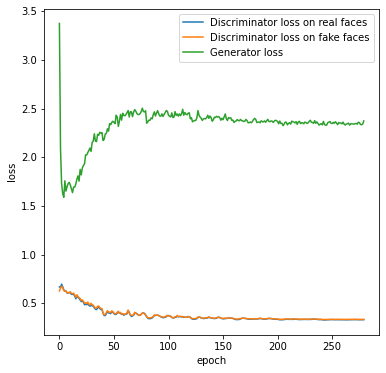

In [8]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(D_losses_real, label="Discriminator loss on real faces")
ax.plot(D_losses_fake, label="Discriminator loss on fake faces")
ax.plot(G_losses, label="Generator loss")
ax.legend()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
plt.show()

In [14]:
images_num = 16
noise_vectors = random_noise_vectors(images_num, latent_size, device=DEVICE)
generated_images = [tensor2image(genim, dataset_mean, dataset_std) for genim in generator(noise_vectors)]

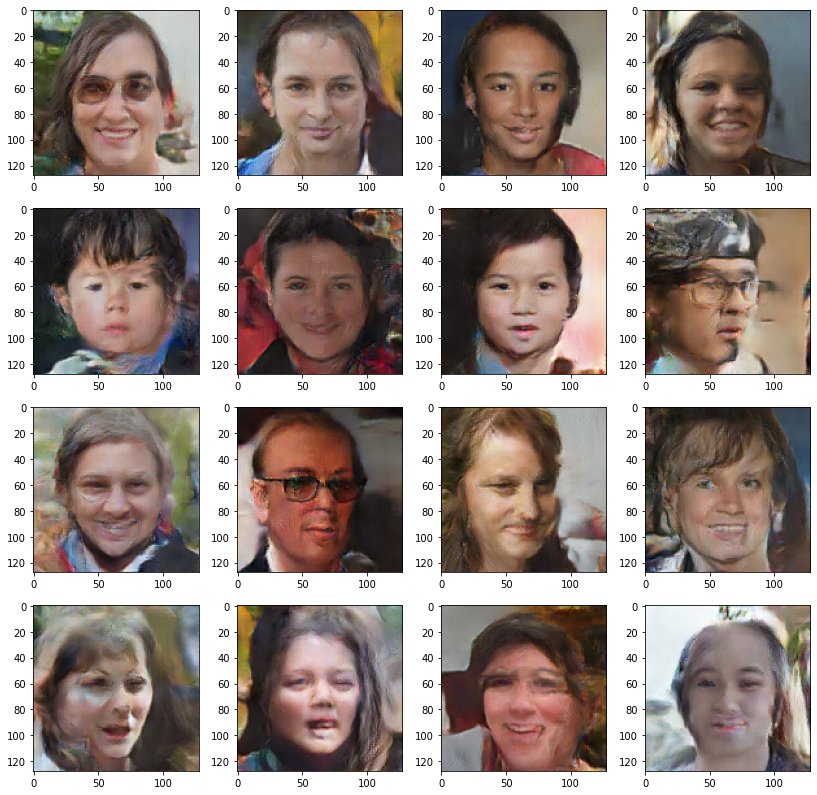

In [15]:
rows_num = 4
cols_num = 4
fig, axs = plt.subplots(rows_num, cols_num, figsize=(14, 14), squeeze=False)
for i in range(images_num):
    axs[i//rows_num, i%cols_num].imshow(generated_images[i])
plt.show()